In [2]:
import numpy as np
import copy
from sklearn import preprocessing
import tensorflow as tf
from tensorflow import keras  #v. 2.9.0
import os
import pandas as pd
from matplotlib import pyplot as plt
from numpy.random import seed
np.random.seed(2095)

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
#from xgboost import XGBClassifier, plot_importance
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix

In [3]:
data = pd.read_csv('CardiacPrediction_csv.csv')

In [4]:
data.head()

,SEQN,Gender,Age,Annual-Family-Income,Ratio-Family-Income-Poverty,X60-sec-pulse,Systolic,Diastolic,Weight,Height,...,Total-Cholesterol,HDL,Glycohemoglobin,Vigorous-work,Moderate-work,Health-Insurance,Diabetes,Blood-Rel-Diabetes,Blood-Rel-Stroke,CoronaryHeartDisease
0,2,1,77,8,5.00,68,98,56,75.4,174.0,...,5.56,1.39,4.7,3,3,1,2,2,2,0
1,5,1,49,11,5.00,66,122,83,92.5,178.3,...,7.21,1.08,5.5,1,1,1,2,2,2,0
2,12,1,37,11,4.93,64,174,99,99.2,180.0,...,4.03,0.98,5.2,2,1,1,2,1,1,0
3,13,1,70,3,1.07,102,130,66,63.6,157.7,...,8.12,1.28,7.6,3,3,1,1,1,2,0
4,14,1,81,5,2.67,72,136,61,75.5,166.2,...,4.50,1.04,5.8,1,1,1,2,2,2,0


In [5]:
data.drop(['SEQN','Annual-Family-Income','Height','Ratio-Family-Income-Poverty','X60-sec-pulse',
          'Health-Insurance','Glucose','Vigorous-work','Total-Cholesterol','CoronaryHeartDisease','Blood-Rel-Stroke','Red-Cell-Distribution-Width','Triglycerides','Mean-Platelet-Vol','Platelet-count','Lymphocyte','Monocyte','Eosinophils','Mean-cell-Hemoglobin','White-Blood-Cells','Red-Blood-Cells','Basophils','Mean-Cell-Vol','Mean-Cell-Hgb-Conc.','Hematocrit','Segmented-Neutrophils'], axis = 1, inplace=True)



In [6]:
#data['Diabetes'] = data['Diabetes'].replace('3','1')

In [7]:
#data = data.astype(float)

In [8]:
data['Diabetes'].loc[(data['Diabetes'] == 3 )] = 1

C:\Users\Eigenaar\AppData\Local\Temp\ipykernel_23184\3794381626.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Diabetes'].loc[(data['Diabetes'] == 3 )] = 1


In [9]:
# data["Diabetes"].describe()

In [10]:
#dropping other features and using only common features (16 instead of 25)

data.drop(['Systolic', 'Diastolic', 'AST','ALT','LDH','Phosphorus','Bilirubin','Uric.Acid','Moderate-work'], axis = 1, inplace=True)

#if you see error it's because it was already dropped

In [11]:
data.head()

,Gender,Age,Weight,Body-Mass-Index,Hemoglobin,Albumin,ALP,Cholesterol,Creatinine,GGT,Iron,Protein,HDL,Glycohemoglobin,Diabetes,Blood-Rel-Diabetes
0,1,77,75.4,24.90,14.1,45,62,5.25,61.9,20,11.28,72.0,1.39,4.7,2,2
1,1,49,92.5,29.10,14.5,45,63,7.16,70.7,34,24.54,73.0,1.08,5.5,2,2
2,1,37,99.2,30.62,16.0,47,63,3.90,88.4,32,11.28,72.0,0.98,5.2,2,1
3,1,70,63.6,25.57,16.8,40,103,7.94,61.9,24,12.18,66.0,1.28,7.6,1,1
4,1,81,75.5,27.33,16.6,45,110,4.42,88.4,24,11.82,79.0,1.04,5.8,2,2


In [12]:
#selecting same amount of diabetics and non diabetics patients randomly to avois bias
#remember 2(no diabetes)=32227, 1 (diabetes)=4852

#1. count number of diab vs no diab (we already know that)
#2. create a subset with 4852 random diabetes
#3. create subset with 4852 diab
#4. combine the two subsets

# all_no_diab = data[data['Diabetes']==2]

# diab_50p = all_no_diab.sample(n=4852)

#diab_50p.value_counts()
#diab_50p.head() 
#print(all_no_diab)


In [13]:
data.shape

(37079, 16)

In [14]:
data.columns

Index(['Gender', 'Age', 'Weight', 'Body-Mass-Index', 'Hemoglobin', 'Albumin',
       'ALP', 'Cholesterol', 'Creatinine', 'GGT', 'Iron', 'Protein', 'HDL',
       'Glycohemoglobin', 'Diabetes', 'Blood-Rel-Diabetes'],
      dtype='object')

In [15]:
# data = data[['Gender', 'Age', 'Systolic', 'Diastolic', 'Weight', 'Body-Mass-Index',
#        'Hemoglobin', 'Albumin', 'ALP', 'AST', 'ALT', 'Cholesterol',
#        'Creatinine', 'GGT', 'Iron', 'LDH', 'Phosphorus',
#        'Bilirubin', 'Protein', 'Uric.Acid', 'HDL',
#        'Glycohemoglobin', 'Moderate-work',
#        'Blood-Rel-Diabetes', 'Diabetes']]


In [16]:
data.columns

Index(['Gender', 'Age', 'Weight', 'Body-Mass-Index', 'Hemoglobin', 'Albumin',
       'ALP', 'Cholesterol', 'Creatinine', 'GGT', 'Iron', 'Protein', 'HDL',
       'Glycohemoglobin', 'Diabetes', 'Blood-Rel-Diabetes'],
      dtype='object')

In [17]:
len(data.columns)

16

In [18]:
data.isnull().sum()

Gender                0
Age                   0
Weight                0
Body-Mass-Index       0
Hemoglobin            0
Albumin               0
ALP                   0
Cholesterol           0
Creatinine            0
GGT                   0
Iron                  0
Protein               0
HDL                   0
Glycohemoglobin       0
Diabetes              0
Blood-Rel-Diabetes    0
dtype: int64

In [19]:
data.describe()

,Gender,Age,Weight,Body-Mass-Index,Hemoglobin,Albumin,ALP,Cholesterol,Creatinine,GGT,Iron,Protein,HDL,Glycohemoglobin,Diabetes,Blood-Rel-Diabetes
count,37079.000000,37079.000000,37079.000000,37079.000000,37079.000000,37079.000000,37079.000000,37079.000000,37079.000000,37079.000000,37079.000000,37079.000000,37079.000000,37079.000000,37079.000000,37079.000000
mean,1.513282,48.943661,80.988276,28.824588,14.139073,42.528116,70.789611,5.077399,78.632276,29.459667,15.266181,72.050158,1.370344,5.676496,1.869144,1.549502
std,0.499830,18.010440,20.678734,6.608982,1.541599,3.585254,26.073559,1.079629,39.157384,43.576787,6.416872,4.967992,0.415985,1.050223,0.337247,0.497550
min,1.000000,20.000000,32.300000,13.180000,5.800000,19.000000,7.000000,0.155000,17.700000,3.000000,0.900000,47.000000,0.160000,2.000000,1.000000,1.000000
25%,1.000000,33.000000,66.500000,24.220000,13.100000,40.000000,55.000000,4.319000,61.880000,14.000000,10.900000,69.000000,1.070000,5.200000,2.000000,1.000000
50%,2.000000,48.000000,78.200000,27.800000,14.100000,43.000000,67.000000,4.991000,73.370000,20.000000,14.500000,72.000000,1.290000,5.400000,2.000000,2.000000
75%,2.000000,63.000000,92.100000,32.100000,15.200000,45.000000,82.000000,5.740000,88.400000,31.000000,18.800000,75.000000,1.600000,5.800000,2.000000,2.000000
max,2.000000,85.000000,371.000000,130.210000,19.700000,57.000000,729.000000,14.611000,1573.520000,2274.000000,99.800000,113.000000,5.840000,18.800000,2.000000,2.000000


In [20]:
data.shape

(37079, 16)

In [21]:
data['Diabetes'].describe()

count    37079.000000
mean         1.869144
std          0.337247
min          1.000000
25%          2.000000
50%          2.000000
75%          2.000000
max          2.000000
Name: Diabetes, dtype: float64

In [22]:
data.columns

Index(['Gender', 'Age', 'Weight', 'Body-Mass-Index', 'Hemoglobin', 'Albumin',
       'ALP', 'Cholesterol', 'Creatinine', 'GGT', 'Iron', 'Protein', 'HDL',
       'Glycohemoglobin', 'Diabetes', 'Blood-Rel-Diabetes'],
      dtype='object')

<AxesSubplot:>

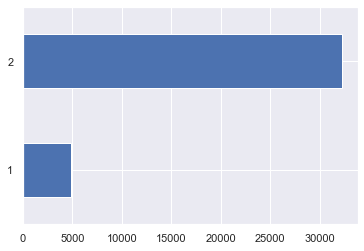

In [23]:
data["Diabetes"].value_counts().sort_index().plot.barh()


In [24]:
#data["Gender"].value_counts().sort_index().plot.barh()
#balanced

In [25]:
#data.corr()

In [26]:
data.columns

Index(['Gender', 'Age', 'Weight', 'Body-Mass-Index', 'Hemoglobin', 'Albumin',
       'ALP', 'Cholesterol', 'Creatinine', 'GGT', 'Iron', 'Protein', 'HDL',
       'Glycohemoglobin', 'Diabetes', 'Blood-Rel-Diabetes'],
      dtype='object')

In [27]:
data.shape

(37079, 16)

In [28]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37079 entries, 0 to 37078
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Gender              37079 non-null  int64  
 1   Age                 37079 non-null  int64  
 2   Weight              37079 non-null  float64
 3   Body-Mass-Index     37079 non-null  float64
 4   Hemoglobin          37079 non-null  float64
 5   Albumin             37079 non-null  int64  
 6   ALP                 37079 non-null  int64  
 7   Cholesterol         37079 non-null  float64
 8   Creatinine          37079 non-null  float64
 9   GGT                 37079 non-null  int64  
 10  Iron                37079 non-null  float64
 11  Protein             37079 non-null  float64
 12  HDL                 37079 non-null  float64
 13  Glycohemoglobin     37079 non-null  float64
 14  Diabetes            37079 non-null  int64  
 15  Blood-Rel-Diabetes  37079 non-null  int64  
dtypes: f

In [29]:
data = data.astype(float)


In [30]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37079 entries, 0 to 37078
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Gender              37079 non-null  float64
 1   Age                 37079 non-null  float64
 2   Weight              37079 non-null  float64
 3   Body-Mass-Index     37079 non-null  float64
 4   Hemoglobin          37079 non-null  float64
 5   Albumin             37079 non-null  float64
 6   ALP                 37079 non-null  float64
 7   Cholesterol         37079 non-null  float64
 8   Creatinine          37079 non-null  float64
 9   GGT                 37079 non-null  float64
 10  Iron                37079 non-null  float64
 11  Protein             37079 non-null  float64
 12  HDL                 37079 non-null  float64
 13  Glycohemoglobin     37079 non-null  float64
 14  Diabetes            37079 non-null  float64
 15  Blood-Rel-Diabetes  37079 non-null  float64
dtypes: f

<AxesSubplot:>

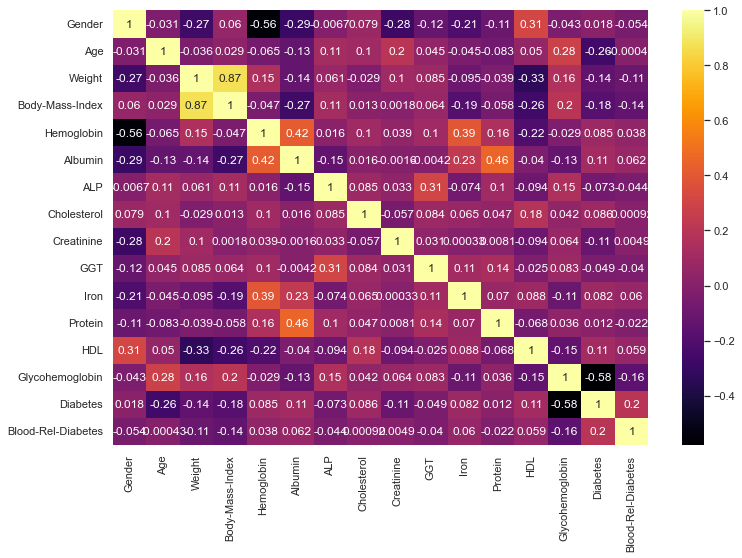

In [31]:
import seaborn as sns
plt.subplots(figsize=(12,8))
sns.heatmap(data.corr(),cmap='inferno', annot=True)

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16]),
 [Text(1, 0, 'Gender'),
  Text(2, 0, 'Age'),
  Text(3, 0, 'Weight'),
  Text(4, 0, 'Body-Mass-Index'),
  Text(5, 0, 'Hemoglobin'),
  Text(6, 0, 'Albumin'),
  Text(7, 0, 'ALP'),
  Text(8, 0, 'Cholesterol'),
  Text(9, 0, 'Creatinine'),
  Text(10, 0, 'GGT'),
  Text(11, 0, 'Iron'),
  Text(12, 0, 'Protein'),
  Text(13, 0, 'HDL'),
  Text(14, 0, 'Glycohemoglobin'),
  Text(15, 0, 'Diabetes'),
  Text(16, 0, 'Blood-Rel-Diabetes')])

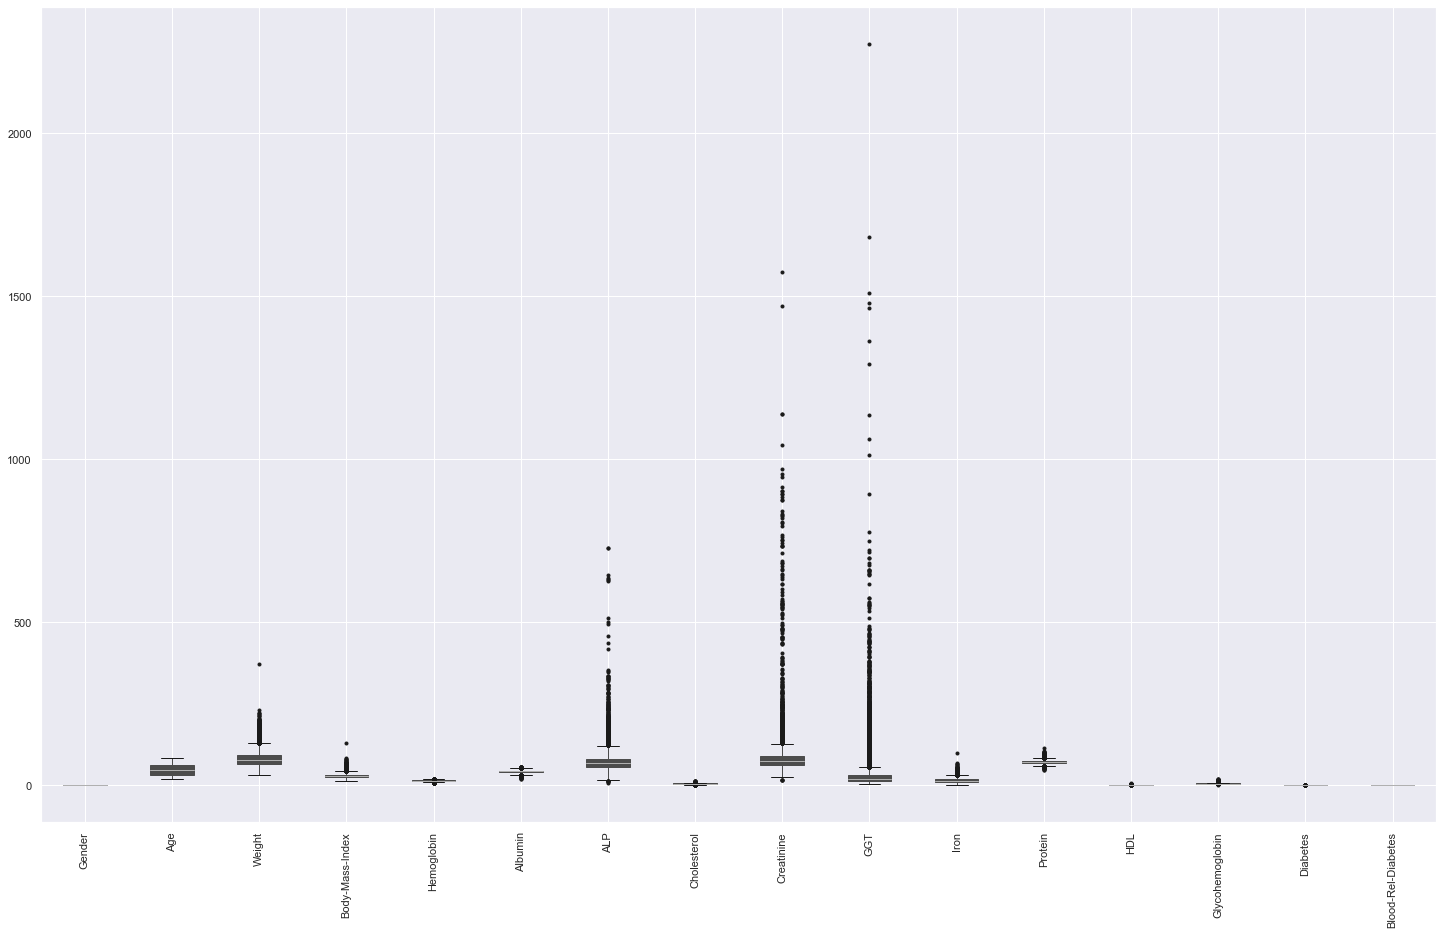

In [32]:
plt.subplots(figsize=(25,15))
data.boxplot(patch_artist=True, sym="k.")
plt.xticks(rotation=90)

In [33]:
minimum = 0
maximum = 0

def detect_outlier(feature):
    first_q = np.percentile(feature, 25)
    third_q = np.percentile(feature, 75) 
    IQR = third_q - first_q
    IQR *= 1.5
    minimum = first_q - IQR 
    maximum = third_q + IQR
    flag = False
    
    if(minimum > np.min(feature)):
        flag = True
    if(maximum < np.max(feature)):
        flag = True
    
    return flag

In [34]:
def  remove_outlier(feature):
    first_q = np.percentile(X[feature], 25)
    third_q = np.percentile(X[feature], 75)
    IQR = third_q - first_q
    IQR *= 1.5
    
    minimum = first_q - IQR # the acceptable minimum value
    maximum = third_q + IQR # the acceptable maximum value
    
    median = X[feature].median()
    
    """
    # any value beyond the acceptance range are considered
    as outliers. 
    # we replace the outliers with the median value of that 
      feature.
    """
    
    X.loc[X[feature] < minimum, feature] = median 
    X.loc[X[feature] > maximum, feature] = median

# taking all the columns except the last one
# last column is the label

X = data.iloc[:, :-1]
for i in range(len(X.columns)): 
        remove_outlier(X.columns[i])

In [35]:
X = data.iloc[:, :-1]


In [36]:
for i in range(len(X.columns)):
    if(detect_outlier(X[X.columns[i]])):
        print(X.columns[i], "Contains Outlier")

Weight Contains Outlier
Body-Mass-Index Contains Outlier
Hemoglobin Contains Outlier
Albumin Contains Outlier
ALP Contains Outlier
Cholesterol Contains Outlier
Creatinine Contains Outlier
GGT Contains Outlier
Iron Contains Outlier
Protein Contains Outlier
HDL Contains Outlier
Glycohemoglobin Contains Outlier
Diabetes Contains Outlier


In [37]:
for i in range (50):
    for i in range(len(X.columns)):
        remove_outlier(X.columns[i])

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
 [Text(1, 0, 'Gender'),
  Text(2, 0, 'Age'),
  Text(3, 0, 'Weight'),
  Text(4, 0, 'Body-Mass-Index'),
  Text(5, 0, 'Hemoglobin'),
  Text(6, 0, 'Albumin'),
  Text(7, 0, 'ALP'),
  Text(8, 0, 'Cholesterol'),
  Text(9, 0, 'Creatinine'),
  Text(10, 0, 'GGT'),
  Text(11, 0, 'Iron'),
  Text(12, 0, 'Protein'),
  Text(13, 0, 'HDL'),
  Text(14, 0, 'Glycohemoglobin'),
  Text(15, 0, 'Diabetes')])

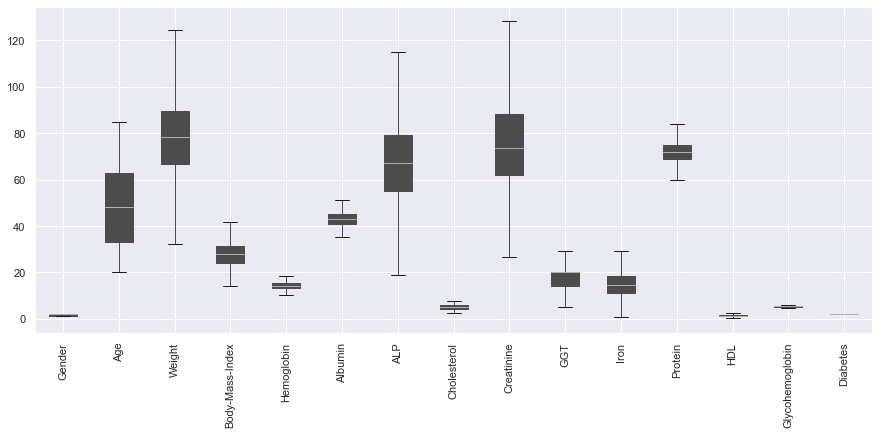

In [38]:
plt.subplots(figsize=(15,6))
X.boxplot(patch_artist=True, sym="k.")
plt.xticks(rotation=90)

In [39]:
for i in range(len(X.columns)):
    if(detect_outlier(X[X.columns[i]])):
        print(X.columns[i], "Contains Outlier")

In [40]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
#from xgboost import XGBClassifier, plot_importance
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix

In [41]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(X)
scaled_df = pd.DataFrame(data = scaled_data, columns = X.columns)
scaled_df.head()


,Gender,Age,Weight,Body-Mass-Index,Hemoglobin,Albumin,ALP,Cholesterol,Creatinine,GGT,Iron,Protein,HDL,Glycohemoglobin,Diabetes
0,-1.026927,1.557803,-0.200522,-0.594546,-0.057520,0.726296,-0.309102,0.224169,-0.716753,0.401809,-0.630587,-0.000498,0.177571,-2.261760,0.0
1,-1.026927,0.003128,0.809160,0.228165,0.220450,0.726296,-0.252824,2.155224,-0.233379,0.401809,1.813833,0.219406,-0.715435,0.338547,0.0
2,-1.026927,-0.663161,1.204766,0.525908,1.262840,1.374143,-0.252824,-1.140713,0.738864,0.401809,-0.630587,-0.000498,-1.003501,-0.636568,0.0
3,-1.026927,1.169134,-0.897262,-0.463304,1.818781,-0.893321,1.998322,-0.037686,-0.716753,1.186672,-0.464676,-1.319924,-0.139302,0.013509,0.0
4,-1.026927,1.779899,-0.194617,-0.118549,1.679795,0.726296,2.392272,-0.614980,0.738864,1.186672,-0.531040,1.538832,-0.830661,1.313662,0.0


In [42]:
label = data["Diabetes"]


In [43]:
encoder = LabelEncoder()
label = encoder.fit_transform(label)

In [44]:
X = scaled_df
y = label 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=420)

In [45]:
print(X_train.shape, y_test.shape)
print(y_train.shape, y_test.shape)

(29663, 15) (7416,)
(29663,) (7416,)


In [46]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

xnew2=SelectKBest(f_classif, k=10).fit_transform(X, y)  #choosing 10 instead of 20 because it has to be less than 14

C:\Users\Eigenaar\AppData\Roaming\Python\Python39\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [14] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\Eigenaar\AppData\Roaming\Python\Python39\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


In [47]:
 import sklearn.feature_selection as fs
 import matplotlib.pyplot as plt
 df2 = fs.SelectKBest(k='all')

 df2.fit(X, y)

 names = X.columns.values[df2.get_support()]

 scores = df2.scores_[df2.get_support()]

 names_scores = list(zip(names, scores))

 ns_df = pd.DataFrame(data = names_scores, columns=

  ['Features','F_Scores'])

 ns_df_sorted = ns_df.sort_values(['F_Scores','Features'], ascending =

  [False, True])

 print(ns_df_sorted)

           Features     F_Scores
1               Age  2686.409705
3   Body-Mass-Index  1000.670115
2            Weight   526.900940
5           Albumin   525.811066
13  Glycohemoglobin   477.417483
12              HDL   378.750379
7       Cholesterol   334.923024
9               GGT   305.472574
4        Hemoglobin   271.220818
10             Iron   211.216877
6               ALP   156.172300
8        Creatinine   102.880413
0            Gender    12.219556
11          Protein     8.581358
14         Diabetes          NaN


C:\Users\Eigenaar\AppData\Roaming\Python\Python39\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [14] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\Eigenaar\AppData\Roaming\Python\Python39\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


In [48]:
#import statsmodels.api as sm
#import pandas
#from patsy import dmatrices
#logit_model = sm.OLS(y_train, X_train)
#result = logit_model.fit()
#print(result.summary2())

In [49]:
#np.exp(result.params)


In [50]:
#params = result.params
#conf = result.conf_int()
#conf['Odds Ratio'] = params.sort_index()
#conf.columns = ['5%', '95%', 'Odds Ratio']
#print(np.exp(conf))

In [51]:
#result.pvalues.sort_values()


In [52]:
#from sklearn.utils import class_weight
#class_weights = class_weight.compute_class_weight('balanced',
                                                # np.unique(y_train),
                                                # y_train)
#model.fit(X_train, y_train, class_weight=class_weights)


Best parameters : {'class_weight': {0: 0.47631578947368414, 1: 0.5236842105263159}}


<AxesSubplot:xlabel='weight'>

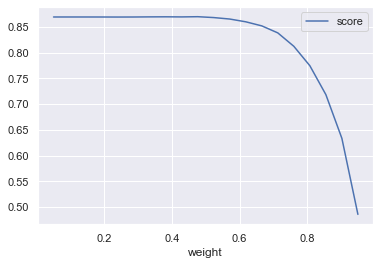

In [53]:
from sklearn.model_selection import GridSearchCV

weights = np.linspace(0.05, 0.95, 20)

gsc = GridSearchCV(
    estimator=LogisticRegression(),
    param_grid={
        'class_weight': [{0: x, 1: 1.0-x} for x in weights]
    },
    scoring='accuracy',
    cv=15
)
grid_result = gsc.fit(X, y)

print("Best parameters : %s" % grid_result.best_params_)

# Plot the weights vs f1 score
dataz = pd.DataFrame({ 'score': grid_result.cv_results_['mean_test_score'],
                       'weight': weights })
dataz.plot(x='weight')

In [54]:
class_weight = {0: 0.5236842105263158,
                1: 0.47631578947368425}

In [55]:
#LR

In [56]:
'''
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from mlxtend.plotting import plot_decision_regions, plot_confusion_matrix
from matplotlib import pyplot as plt
lr = LogisticRegression(class_weight='balanced',random_state=420)

# Fit..
lr.fit(X_train, y_train)

# Predict..
y_pred = lr.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))
plot_confusion_matrix(confusion_matrix(y_test, y_pred))
from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc
'''

"\nfrom sklearn.linear_model import LogisticRegression\nfrom sklearn.metrics import confusion_matrix, classification_report\nfrom mlxtend.plotting import plot_decision_regions, plot_confusion_matrix\nfrom matplotlib import pyplot as plt\nlr = LogisticRegression(class_weight='balanced',random_state=420)\n\n# Fit..\nlr.fit(X_train, y_train)\n\n# Predict..\ny_pred = lr.predict(X_test)\n\n# Evaluate the model\nprint(classification_report(y_test, y_pred))\nplot_confusion_matrix(confusion_matrix(y_test, y_pred))\nfrom sklearn.metrics import roc_curve, auc\nfalse_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)\nroc_auc = auc(false_positive_rate, true_positive_rate)\nroc_auc\n"

In [57]:
'''
from sklearn.svm import SVC

clf_svc_rbf = SVC(kernel="rbf",class_weight='balanced',random_state=4200)
clf_svc_rbf.fit(X_train,y_train)
y_pred_clf_svc_rbf = clf_svc_rbf.predict(X_test)


import matplotlib.pyplot as plt
cm = confusion_matrix(y_test,y_pred_clf_svc_rbf)

#plt.figure(figsize=(5,5))
#sns.heatmap(cm,annot=True)
#plt.show()

#print(classification_report(y_test,y_pred_clf_svc_rbf))

print(classification_report(y_test, y_pred_clf_svc_rbf))
plot_confusion_matrix(confusion_matrix(y_test, y_pred_clf_svc_rbf))

from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_clf_svc_rbf)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc
'''

'\nfrom sklearn.svm import SVC\n\nclf_svc_rbf = SVC(kernel="rbf",class_weight=\'balanced\',random_state=4200)\nclf_svc_rbf.fit(X_train,y_train)\ny_pred_clf_svc_rbf = clf_svc_rbf.predict(X_test)\n\n\nimport matplotlib.pyplot as plt\ncm = confusion_matrix(y_test,y_pred_clf_svc_rbf)\n\n#plt.figure(figsize=(5,5))\n#sns.heatmap(cm,annot=True)\n#plt.show()\n\n#print(classification_report(y_test,y_pred_clf_svc_rbf))\n\nprint(classification_report(y_test, y_pred_clf_svc_rbf))\nplot_confusion_matrix(confusion_matrix(y_test, y_pred_clf_svc_rbf))\n\nfrom sklearn.metrics import roc_curve, auc\nfalse_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_clf_svc_rbf)\nroc_auc = auc(false_positive_rate, true_positive_rate)\nroc_auc\n'

              precision    recall  f1-score   support

           0       0.65      0.26      0.37       951
           1       0.90      0.98      0.94      6465

    accuracy                           0.89      7416
   macro avg       0.77      0.62      0.65      7416
weighted avg       0.87      0.89      0.87      7416



0.619870889355691

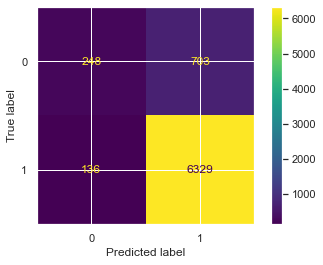

In [58]:

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

rd = RandomForestClassifier(class_weight='balanced',random_state=4200)
rd.fit(X_train,y_train)
y_pred_rd = rd.predict(X_test)


import matplotlib.pyplot as plt
cm = confusion_matrix(y_test,y_pred_rd)

#plt.figure(figsize=(5,5))
#sns.heatmap(cm,annot=True,linewidths=.3)
#plt.show()

print(classification_report(y_test,y_pred_rd))
ConfusionMatrixDisplay.from_predictions(y_test,y_pred_rd)  #added by Elena becuase of confusion matrix error 


from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_rd)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc


In [59]:
#CV appraoach

## SVM

In [60]:

# evaluate a logistic regression model using k-fold cross-validation
from numpy import mean
from numpy import std
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit

from sklearn.linear_model import LogisticRegression
# create dataset
#X, y = make_classification(n_samples=1000, n_features=20, n_informative=15, n_redundant=5, random_state=1)
# prepare the cross-validation procedure
#cv = KFold(n_splits=5, test_size= 0.2, random_state=0)
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
# create model
model = SVC(kernel='rbf', C=1, class_weight=class_weight)
# evaluate model
scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
# report performance
print('Accuracy: %.4f (%.4f)' % (mean(scores), std(scores)))
scores

Accuracy: 0.8737 (0.0034)


array([0.87634844, 0.87392125, 0.87351672, 0.87540453, 0.86933657,
       0.87769687, 0.86798813, 0.87270766, 0.87122438, 0.87918015])

C:\Users\Eigenaar\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Eigenaar\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Eigenaar\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Functio

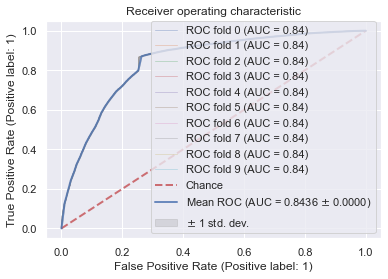

In [61]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import StratifiedKFold



# #############################################################################
# Classification and ROC analysis

# Run classifier with cross-validation and plot ROC curves
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
classifier = svm.SVC(kernel='rbf', probability=True, class_weight=class_weight,
                     random_state=42)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots()
for i, (train, test) in enumerate(cv.split(X, y)):
    classifier.fit(X, y)
    viz = plot_roc_curve(classifier, X, y,
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.4f $\pm$ %0.4f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Receiver operating characteristic")
ax.legend(loc="lower right")
plt.show()

# LR

In [62]:
from numpy import mean
from numpy import std
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit

from sklearn.linear_model import LogisticRegression
# create dataset
#X, y = make_classification(n_samples=1000, n_features=20, n_informative=15, n_redundant=5, random_state=1)
# prepare the cross-validation procedure
#cv = KFold(n_splits=5, test_size= 0.2, random_state=0)
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
# create model
model = LogisticRegression(class_weight=class_weight)
# evaluate model
scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
# report performance
print('Accuracy: %.4f (%.4f)' % (mean(scores), std(scores)))
scores

Accuracy: 0.8681 (0.0042)


array([0.86947141, 0.86987594, 0.86610032, 0.87014563, 0.86326861,
       0.87081985, 0.86016721, 0.87108954, 0.86515642, 0.87513484])

C:\Users\Eigenaar\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Eigenaar\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Eigenaar\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Functio

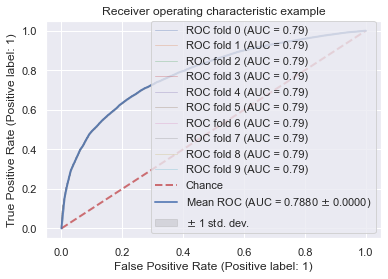

In [63]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import StratifiedKFold

# #############################################################################
# Data IO and generation

# Import some data to play with
#iris = datasets.load_iris()
#X = iris.data
#y = iris.target
#X, y = X[y != 2], y[y != 2]
#n_samples, n_features = X.shape

# Add noisy features
#random_state = np.random.RandomState(0)
#X = np.c_[X, random_state.randn(n_samples, 200 * n_features)]

# #############################################################################
# Classification and ROC analysis

# Run classifier with cross-validation and plot ROC curves
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
classifier = LogisticRegression(class_weight=class_weight,random_state=42)
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots()
for i, (train, test) in enumerate(cv.split(X, y)):
    classifier.fit(X, y)
    viz = plot_roc_curve(classifier, X, y,
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.4f $\pm$ %0.4f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Receiver operating characteristic example")
ax.legend(loc="lower right")
plt.show()

## RF

In [64]:
from numpy import mean
from numpy import std
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import ShuffleSplit

# create dataset
#X, y = make_classification(n_samples=1000, n_features=20, n_informative=15, n_redundant=5, random_state=1)
# prepare the cross-validation procedure
#cv = KFold(n_splits=5, test_size= 0.2, random_state=0)
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
# create model
model = RandomForestClassifier(class_weight=class_weight)
# evaluate model
scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
# report performance
print('Accuracy: %.4f (%.4f)' % (mean(scores), std(scores)))
scores

Accuracy: 0.8899 (0.0033)


array([0.89131607, 0.89482201, 0.88821467, 0.88875405, 0.88511327,
       0.89563107, 0.88700108, 0.88821467, 0.88781014, 0.89252967])

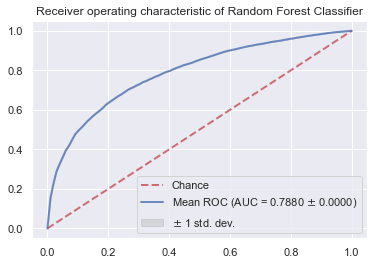

In [65]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import StratifiedKFold

# #############################################################################
# Data IO and generation

# Import some data to play with
#iris = datasets.load_iris()
#X = iris.data
#y = iris.target
#X, y = X[y != 2], y[y != 2]
#n_samples, n_features = X.shape

# Add noisy features
#random_state = np.random.RandomState(0)
#X = np.c_[X, random_state.randn(n_samples, 200 * n_features)]

# #############################################################################
# Classification and ROC analysis

# Run classifier with cross-validation and plot ROC curves
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
classifier = RandomForestClassifier(class_weight=class_weight,random_state=42)
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots()
for i, (train, test) in enumerate(cv.split(X, y)):
    classifier.fit(X, y)
    #viz = plot_roc_curve(classifier, X, y,
                  #       name='ROC fold {}'.format(i),
                    #     alpha=0.3, lw=1, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.4f $\pm$ %0.4f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Receiver operating characteristic of Random Forest Classifier")
ax.legend(loc="lower right")
plt.show()

## DT

In [66]:
from numpy import mean
from numpy import std
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
from sklearn.tree import DecisionTreeClassifier


# create dataset
#X, y = make_classification(n_samples=1000, n_features=20, n_informative=15, n_redundant=5, random_state=1)
# prepare the cross-validation procedure
#cv = KFold(n_splits=5, test_size= 0.2, random_state=0)
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
# create model
model = DecisionTreeClassifier(class_weight=class_weight)
# evaluate model
scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
# report performance
print('Accuracy: %.4f (%.4f)' % (mean(scores), std(scores)))
scores

Accuracy: 0.8397 (0.0044)


array([0.84277238, 0.84600863, 0.84074973, 0.84088457, 0.83171521,
       0.84466019, 0.83265912, 0.83994067, 0.8381877 , 0.83913161])

C:\Users\Eigenaar\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Eigenaar\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Eigenaar\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Functio

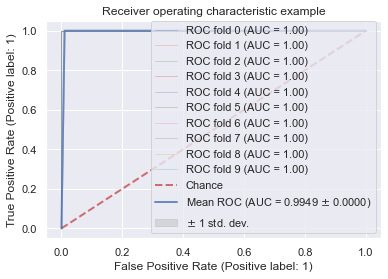

In [67]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import StratifiedKFold

# #############################################################################
# Data IO and generation

# Import some data to play with
#iris = datasets.load_iris()
#X = iris.data
#y = iris.target
#X, y = X[y != 2], y[y != 2]
#n_samples, n_features = X.shape

# Add noisy features
#random_state = np.random.RandomState(0)
#X = np.c_[X, random_state.randn(n_samples, 200 * n_features)]

# #############################################################################
# Classification and ROC analysis

# Run classifier with cross-validation and plot ROC curves
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
classifier = DecisionTreeClassifier(class_weight=class_weight,random_state=42)
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots()
for i, (train, test) in enumerate(cv.split(X, y)):
    classifier.fit(X, y)
    viz = plot_roc_curve(classifier, X, y,
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.4f $\pm$ %0.4f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Receiver operating characteristic example")
ax.legend(loc="lower right")
plt.show()

In [68]:
#from sklearn.model_selection import cross_val_score
#from sklearn import svm
#clf = svm.SVC(kernel='rbf', C=1, class_weight=class_weight)
#scores = cross_val_score(clf, X, y, cv=5)
#print("Accuracy: %0.4f (+/- %0.4f)" % (scores.mean(), scores.std() * 2))

#clf.score(X_test, y_test)

## ANN

In [69]:
import keras
from keras.models import Sequential
from keras.layers import Dense,Dropout

In [70]:
classifier=Sequential()
classifier.add(Dense(units=256, kernel_initializer='uniform',activation='relu',input_dim=(len(data.columns)-1)))  #changed to length-1 so there is no need to change it everytime we change number of attributes
classifier.add(Dense(units=128, kernel_initializer='uniform',activation='relu'))
classifier.add(Dropout(0.5))
classifier.add(Dense(units=64, kernel_initializer='uniform',activation='relu'))
classifier.add(Dropout(0.4))
classifier.add(Dense(units=32, kernel_initializer='uniform',activation='relu'))

classifier.add(Dense(units=1, kernel_initializer='uniform',activation='sigmoid'))
classifier.compile(optimizer='adam',loss="binary_crossentropy",metrics=['accuracy'])
classifier.fit(X_train,y_train,batch_size=10,epochs=100,class_weight=class_weight,validation_data=(X_test, y_test))

Epoch 1/100
2967/2967 [==============================] - 7s 2ms/step - loss: 0.1603 - accuracy: 0.8750 - val_loss: 0.2913 - val_accuracy: 0.8855
Epoch 2/100
2967/2967 [==============================] - 7s 2ms/step - loss: 0.1477 - accuracy: 0.8864 - val_loss: 0.2798 - val_accuracy: 0.8894
Epoch 3/100
2967/2967 [==============================] - 6s 2ms/step - loss: 0.1418 - accuracy: 0.8864 - val_loss: 0.2739 - val_accuracy: 0.8889
Epoch 4/100
2967/2967 [==============================] - 7s 2ms/step - loss: 0.1391 - accuracy: 0.8876 - val_loss: 0.2780 - val_accuracy: 0.8878
Epoch 5/100
2967/2967 [==============================] - 7s 2ms/step - loss: 0.1370 - accuracy: 0.8907 - val_loss: 0.2640 - val_accuracy: 0.8909
Epoch 6/100
2967/2967 [==============================] - 7s 2ms/step - loss: 0.1346 - accuracy: 0.8910 - val_loss: 0.2624 - val_accuracy: 0.8893
Epoch 7/100
2967/2967 [==============================] - 7s 2ms/step - loss: 0.1347 - accuracy: 0.8904 - val_loss: 0.2607 - val_ac

In [71]:
#clf_svc_rbf.fit(X_train,y_train)
from sklearn.metrics import confusion_matrix,classification_report,roc_auc_score,auc,f1_score
y_pred = classifier.predict(X_test)>0.9


import matplotlib.pyplot as plt
cm = confusion_matrix(y_test,y_pred)

#plt.figure(figsize=(5,5))
#sns.heatmap(cm,annot=True)
#plt.show()

#print(classification_report(y_test,y_pred_clf_svc_rbf))

print(classification_report(y_test, y_pred))
#plot_confusion_matrix(confusion_matrix(y_test, y_pred))

from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

232/232 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.33      0.72      0.46       951
           1       0.95      0.79      0.86      6465

    accuracy                           0.78      7416
   macro avg       0.64      0.76      0.66      7416
weighted avg       0.87      0.78      0.81      7416



0.7558310826800949

AUC Score: 0.7558310826800949


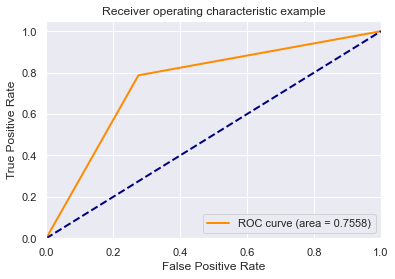

In [72]:
from sklearn.metrics import roc_curve,roc_auc_score
from sklearn.metrics import auc

fpr , tpr , thresholds = roc_curve ( y_test , y_pred)
auc_keras = auc(fpr, tpr)
print("AUC Score:",auc_keras)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.4f)' % auc_keras)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [73]:
#from sklearn.tree import DecisionTreeClassifier


#from sklearn.model_selection import cross_val_score

#dt = DecisionTreeClassifier(class_weight=class_weight)
#scores = cross_val_score(clf, X, y, cv=5)
#print("Accuracy: %0.4f (+/- %0.4f)" % (scores.mean(), scores.std() * 2))

In [74]:
'''

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,classification_report,roc_auc_score,auc,f1_score

lr = LogisticRegression()
lr.fit(X_train,y_train)
y_pred_logistic = lr.predict(X_test)

import matplotlib.pyplot as plt
cm = confusion_matrix(y_test,y_pred_logistic)

plt.figure(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidths=.3)
plt.show()

print(classification_report(y_test,y_pred_logistic))


from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_logistic)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc
print(f1_score(y_test, y_pred_logistic,average="macro"))
'''

'\n\nfrom sklearn.linear_model import LogisticRegression\nfrom sklearn.metrics import confusion_matrix,classification_report,roc_auc_score,auc,f1_score\n\nlr = LogisticRegression()\nlr.fit(X_train,y_train)\ny_pred_logistic = lr.predict(X_test)\n\nimport matplotlib.pyplot as plt\ncm = confusion_matrix(y_test,y_pred_logistic)\n\nplt.figure(figsize=(5,5))\nsns.heatmap(cm,annot=True,linewidths=.3)\nplt.show()\n\nprint(classification_report(y_test,y_pred_logistic))\n\n\nfrom sklearn.metrics import roc_curve, auc\nfalse_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_logistic)\nroc_auc = auc(false_positive_rate, true_positive_rate)\nroc_auc\nprint(f1_score(y_test, y_pred_logistic,average="macro"))\n'

In [75]:
from sklearn import datasets
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier

In [76]:
clf1 = SVC(kernel='rbf', C=1, class_weight=class_weight,random_state=42)
clf2 = LogisticRegression(class_weight=class_weight,random_state=42)
clf3 = RandomForestClassifier(class_weight=class_weight,random_state=42)
clf4 = DecisionTreeClassifier(class_weight=class_weight,random_state=42)
#clf5 = Sequential()

In [77]:
eclf = VotingClassifier( estimators=[('svm', clf1), ('lr', clf2), ('rf', clf3), ('dt',clf4)],
     voting='hard')

In [82]:
acc_score_list=[]
for clf, label in zip([clf1, clf2, clf3,clf4 ,eclf], ['SVM', 'LR', 'RF','DT', 'Ensemble']):
    scores = cross_val_score(clf, X, y, scoring='accuracy', cv=10)
    acc_score_list.append("%0.4f (+/- %0.4f)" % (scores.mean(), scores.std()))
scores
print("Accuracy:", acc_score_list)

Accuracy: ['0.8729 (+/- 0.0018)', '0.8674 (+/- 0.0029)', '0.8890 (+/- 0.0047)', '0.8365 (+/- 0.0078)', '0.8822 (+/- 0.0044)']


In [83]:
#adding nice table for comparative purposes (to be tested)

import plotly.graph_objects as go
paper_accuracy=[0.89, 0.88, 0.90, 0.86, 0.90]  #taken from the paper diabetic study, table II
fig = go.Figure(data=[go.Table(header=dict(values=['Method', 'Paper Accuracy','Lab Accuracy']),
                 cells=dict(values=[['SVM', 'LR', 'RF','DT', 'Ensemble'], paper_accuracy, acc_score_list]))
                     ])
fig.show()
